# **2.Training AlexNet on CIFAR-10 to achieve high accuracy in classifying 10 different classes of images.(EX-4)**

In [1]:
pip install torch torchvision


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x)) # Remove pooling here
        x = F.relu(self.conv4(x)) # Remove pooling here
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
import torch.optim as optim

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50  # You can increase this for better accuracy
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 100] loss: 2.153
[1, 200] loss: 1.896
[1, 300] loss: 1.799
[1, 400] loss: 1.712
[1, 500] loss: 1.669
[1, 600] loss: 1.602
[1, 700] loss: 1.558
[2, 100] loss: 1.511
[2, 200] loss: 1.435
[2, 300] loss: 1.433
[2, 400] loss: 1.408
[2, 500] loss: 1.366
[2, 600] loss: 1.348
[2, 700] loss: 1.327
[3, 100] loss: 1.275
[3, 200] loss: 1.305
[3, 300] loss: 1.254
[3, 400] loss: 1.224
[3, 500] loss: 1.234
[3, 600] loss: 1.240
[3, 700] loss: 1.247
[4, 100] loss: 1.161
[4, 200] loss: 1.144
[4, 300] loss: 1.145
[4, 400] loss: 1.148
[4, 500] loss: 1.175
[4, 600] loss: 1.156
[4, 700] loss: 1.148
[5, 100] loss: 1.060
[5, 200] loss: 1.082
[5, 300] loss: 1.079
[5, 400] loss: 1.069
[5, 500] loss: 1.061
[5, 600] loss: 1.060
[5, 700] loss: 1.093
[6, 100] loss: 0.996
[6, 200] loss: 0.989
[6, 300] loss: 0.985
[6, 400] loss: 1.027
[6, 500] loss: 0.981
[6, 600] loss: 1.014
[6, 700] loss: 1.025
[7, 100] loss: 0.940
[7, 200] loss: 0.901
[7, 300] loss: 0.916
[7, 400] loss: 0.956
[7, 500] loss: 0.954
[7, 600] loss

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test images: {100 * correct / total:.2f}%')


Accuracy on the test images: 61.97%


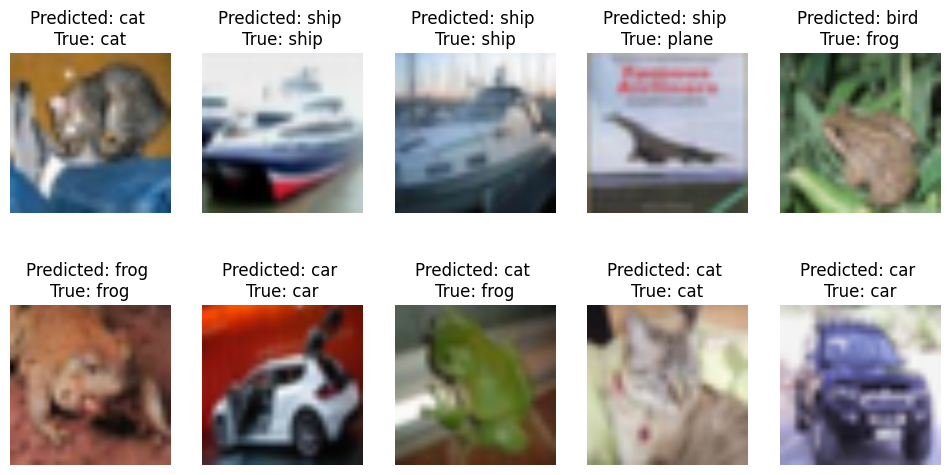

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Unnormalize and convert the image tensor to numpy for display
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images to the device
images, labels = images.to(device), labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the images and their predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 images
    plt.subplot(2, 5, i + 1)
    imshow(images[i].cpu())
    plt.title(f'Predicted: {classes[predicted[i].item()]} \nTrue: {classes[labels[i].item()]}')
plt.show()
